# CLFO
## 03 Convolutional neural network

### Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split as split
from torch.utils.data import DataLoader, Dataset
import pickle
from PIL import Image

D:\PROJEKAT_CLFO\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\PROJEKAT_CLFO\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Loading all gray images

In [ ]:
with open("D:\\PROJEKAT_CLFO\\tr2_grey_256.npy","rb")as f:
    X=np.load(f)
    y=np.load(f)
    
print(np.unique(y,return_counts=True))

X = np.reshape(X, (6000,1,256,256))
X = torch.from_numpy(X)
y = torch.from_numpy(y)

chanels = 1

PATH = 'D:\\PROJEKAT_CLFO\\BW_256.pth'# pyTorch file extension - saves model

### Loading 715 color images (143 for each class)

In [3]:
name = 'nochers_5x143' #enter name of the pickle file
with open(name, 'rb') as f:
    image_paths = pickle.load(f)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

categories = 5
samples_per_category = len(image_paths[0])
X = torch.zeros((samples_per_category*categories, 3, 224, 224))
labels = []

for i in range(samples_per_category):
    for j in range(categories):
        path = image_paths[j][i]
        input_image = Image.open(path)
        inx = i*categories+j
        if inx % 50 == 0 and j == 0:
            print(f'{inx}/{categories*samples_per_category}')
        try:
            input_tensor = preprocess(input_image)
            X[inx] = input_tensor
        except:
            print(inx, path)
            print('Mistake')
        labels.append(j)

y = torch.tensor(labels)

chanels = 3

PATH = 'D:\\PROJEKAT_CLFO\\color_right_notchers_256.pth'# pyTorch file extension - saves model

0/715
50/715
100/715
150/715
200/715
250/715
300/715
350/715
400/715
450/715
500/715
550/715
600/715
650/715
700/715


### Model parameters

In [43]:
input_size=X.shape[2]*X.shape[3]
num_classes=5
dim = X.shape[2]
test_size=0.2
batch_size=5
learning_rate=0.001
hidden_size=100
num_epochs=5

### Spliting train and test size

In [7]:
X_train, X_test, y_train, y_test = split(X, y, test_size = test_size, random_state = 7)

In [62]:
classes = np.unique(y_test)

### Transform two numpy arrays into one torch Data instance

In [9]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=X
        self.y=y
        self.samples=X.shape[0]
        self.features=X.shape[2]*X.shape[3]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.samples

### Creating data instance

In [10]:
train_data=Data(X_train, y_train)
test_data=Data(X_test,y_test)

In [11]:
train_data.samples, test_data.samples

(572, 143)

In [12]:
train_data[0][0].size()

torch.Size([3, 224, 224])

In [13]:
train_data.features

50176

### Devide train and test data in 100 samples batches

In [16]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size)

In [17]:
len(train_loader)

115

### Example

In [18]:
examples=iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels)

torch.Size([5, 3, 224, 224]) tensor([4, 3, 0, 1, 0])


### Allow GPU usage

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

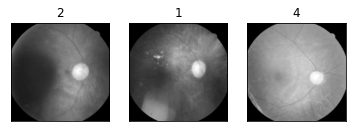

In [61]:
for i in range(3):
    ax = plt.subplot(1,3,i+1, title = f'{labels[i]}') 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

<img src='convolution.png'>

<img src='maxpooling.png'>

In [21]:
learning_rate = 0.01
num_epochs = 5

### Convolutional network class creation

In [26]:
last_dim = (((dim - 4) / 2)-2)/2
last_dim

62.0

In [40]:
# convolution_1 -> 252 (sharpen image and reduce dimension by (kernel_size - 1))
# max_pool -> 126 (square 2X2 of 4 pixelx transforms into 1 by selecting one with highest value)
# convolution_2 -> 122
# max_pool -> 61

last_dim = int((((dim - 4) / 2)-2)/2)
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution1 = nn.Conv2d(chanels,6,5) # number of color chanels, output nodes, kernel size
        self.pool = nn.MaxPool2d(2) # kernel size (look sketch above), second parameter is stride (default value is kernel size)
        self.convolution2 = nn.Conv2d(6,16,3) # input size must be number of hidden layers (6)
        self.fc1 = nn.Linear(16*last_dim*last_dim, 120) # 16 hidden layers x 61X61 image -> flatten to 16*61*61, 120 is optional
        self.fc2 = nn.Linear(120, 84) # 84 is optional
        self.fc3 = nn.Linear(84, 5) # we have 5 classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.convolution1(x)))
        x = self.pool(F.relu(self.convolution2(x)))
        x = x.view(-1, 16 * last_dim * last_dim)          
        x = F.relu(self.fc1(x))            
        x = F.relu(self.fc2(x))               
        x = self.fc3(x)                       
        return x
print(last_dim)

54


### Cross-Entropy - criterion for optimization

Cross-entropy is calculated for all model at once

Training labels are presented as:
Y = [1,0,0]

Probabilities calculated by Softmax:
P = [0.7,0.1,0.2]

Cross-Entropy 
\begin{align}
D(P,Y)=-\frac{1}{N}\sum Y_i\cdot log(P_i) 
\end{align}

Bigger h for x > Softmax values closer to 1 > log(Pi) closer to zero 

In [41]:
model = ConvolutionalNetwork().to(device)
model.double()
criterion = nn.CrossEntropyLoss()

# SGD stochastig gradiant descent
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### Training

In [44]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    #for 48 baches (48X100)
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device).double()
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_total_steps}, Loss: {loss.item():.4f}')
            
print('\n\nfinished training')
torch.save(model.state_dict(), PATH)

Epoch: 1/5, Step: 20/115, Loss: 1.6531
Epoch: 1/5, Step: 40/115, Loss: 1.5731
Epoch: 1/5, Step: 60/115, Loss: 1.6100
Epoch: 1/5, Step: 80/115, Loss: 1.5975
Epoch: 1/5, Step: 100/115, Loss: 1.6385
Epoch: 2/5, Step: 20/115, Loss: 1.6530
Epoch: 2/5, Step: 40/115, Loss: 1.5643
Epoch: 2/5, Step: 60/115, Loss: 1.6095
Epoch: 2/5, Step: 80/115, Loss: 1.5954
Epoch: 2/5, Step: 100/115, Loss: 1.6394
Epoch: 3/5, Step: 20/115, Loss: 1.6498
Epoch: 3/5, Step: 40/115, Loss: 1.5578
Epoch: 3/5, Step: 60/115, Loss: 1.6086
Epoch: 3/5, Step: 80/115, Loss: 1.5950
Epoch: 3/5, Step: 100/115, Loss: 1.6405
Epoch: 4/5, Step: 20/115, Loss: 1.6487
Epoch: 4/5, Step: 40/115, Loss: 1.5508
Epoch: 4/5, Step: 60/115, Loss: 1.6072
Epoch: 4/5, Step: 80/115, Loss: 1.5889
Epoch: 4/5, Step: 100/115, Loss: 1.6419
Epoch: 5/5, Step: 20/115, Loss: 1.6477
Epoch: 5/5, Step: 40/115, Loss: 1.5466
Epoch: 5/5, Step: 60/115, Loss: 1.6060
Epoch: 5/5, Step: 80/115, Loss: 1.5873
Epoch: 5/5, Step: 100/115, Loss: 1.6429


finished training


### Testing

In [56]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]

    for images, labels in test_loader:
        images = images.to(device).double()
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(labels.shape[0]):
            label = labels[i].int()
            pred = predicted[i].int()
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 19.58041958041958 %
Accuracy of 0: 78.26086956521739 %
Accuracy of 1: 0.0 %
Accuracy of 2: 0.0 %
Accuracy of 3: 0.0 %
Accuracy of 4: 33.333333333333336 %


# CLFO_project

- instaling Open CV library
- creating functions for image resize, load, transform color, save with aim to better understand problem
- selecting areas that are connected to illness levels
- simulate ml algorithms to check mask importance
- simulate deeep learning to check mask importance
- problem - to much time for creating masks on 6000 images
- selecting equal image sets for each level
- asigning each image to corespodent level
- princips of PyTorch functioning (gradients, forward & backward pass, linear regression, logistic regression, sigmoid functions, ReLU, softmax, cross entreopy, neural networks - nonlinearity)
- 256x256 gray images (one chanel) 1200 for each class
- creating feedForward neural network model on 256x256 gray images
- creating convolutional neural network model on 256x256 gray images